## LDA Modeling, Bi-Gram

In [1]:
#set up sys
import os, sys
sys.path.append('../PMC_func')


#python basics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import logging
from collections import Counter

#spacy stuff
import spacy
from spacy.language import Language
from spacy.tokens import Doc
from spacy.attrs import LOWER, POS, ENT_TYPE, IS_ALPHA, DEP, LEMMA, LOWER, IS_PUNCT, IS_DIGIT, IS_SPACE, IS_STOP
import en_core_web_sm

#gensim stuff
from gensim.models import CoherenceModel, LdaMulticore,LdaModel
from gensim.models.callbacks import ConvergenceMetric
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS


# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis  # don't skip this

#custom dependencies
import PMC_module

#other
import pickle
import warnings
warnings.filterwarnings('ignore')

### Import Data
- Pickled Gensim Objects
- Composite Data Frame

In [2]:
nogram_filename = "../pickled_data/nogram_corpus.pkl"
bigram_filename = "../pickled_data/bigram_corpus.pkl"
trigram_filename = "../pickled_data/trigram_corpus.pkl"
df_lemmatized_texts = "../pickled_data/df_lemmatized_texts.pkl"

with open(nogram_filename, "rb") as f:
    nogram_list_lemmatized_texts, nogram_corpus, nogram_id2word = pickle.load(f)

with open(bigram_filename, "rb") as g:
    bigram_list_lemmatized_texts, bi_corpus, bi_id2word = pickle.load(g)
    
with open(trigram_filename, "rb") as h:
    trigram_list_lemmatized_texts, tri_corpus, tri_id2word = pickle.load(h)
    
with open(df_lemmatized_texts, "rb") as m:
    df_lemmatized_texts = pickle.load(m)

In [3]:
# store raw texts as a list for later
df_list = df_lemmatized_texts.text.tolist()

### Gensim LDA modeling - Hyper Parameter Tunning

#### Coherence Score

In [4]:
logging.basicConfig(filename='model_callbacks.log',
                    format="%(asctime)s:%(levelname)s:%(message)s",
                    level=logging.NOTSET)

convergence_logger = ConvergenceMetric(logger='shell')

In [5]:
num_topics_list = list(range(5,20,5))
model_lists = []
coherence_list = []

chunksize = 1000
passes = 4
iterations = 200
eval_every = 1
callbacks = [convergence_logger]

for num_topics in num_topics_list:
    lda_model = LdaModel(id2word=bi_id2word, 
                         num_topics=num_topics,
                         corpus=bi_corpus,
                         chunksize=chunksize,
                         alpha='auto',
                         eta='auto',
                         iterations=iterations,
                         passes=passes,
                         eval_every=eval_every,
                         callbacks= callbacks)
                             
    coherence_model_lda = CoherenceModel(model=lda_model, texts=bigram_list_lemmatized_texts, dictionary=bi_id2word, coherence='c_v')
    coherence_score = coherence_model_lda.get_coherence()
    model_lists.append(lda_model)
    coherence_list.append(coherence_score)
    print("LDA model/coherence complete for num_topics = ",num_topics, "; score = ", coherence_score)

LDA model/coherence complete for num_topics =  5 ; score =  0.49994976319076817
LDA model/coherence complete for num_topics =  10 ; score =  0.4586911614568555
LDA model/coherence complete for num_topics =  15 ; score =  0.43942653326206205


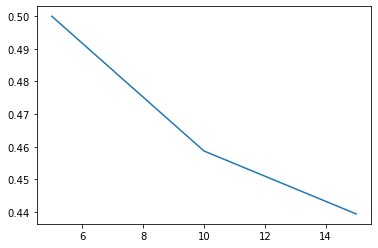

In [6]:
plt.plot(num_topics_list,coherence_list)

#### Topic Component Distribution - 5 topics

In [7]:
opt_topic_index = 0
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

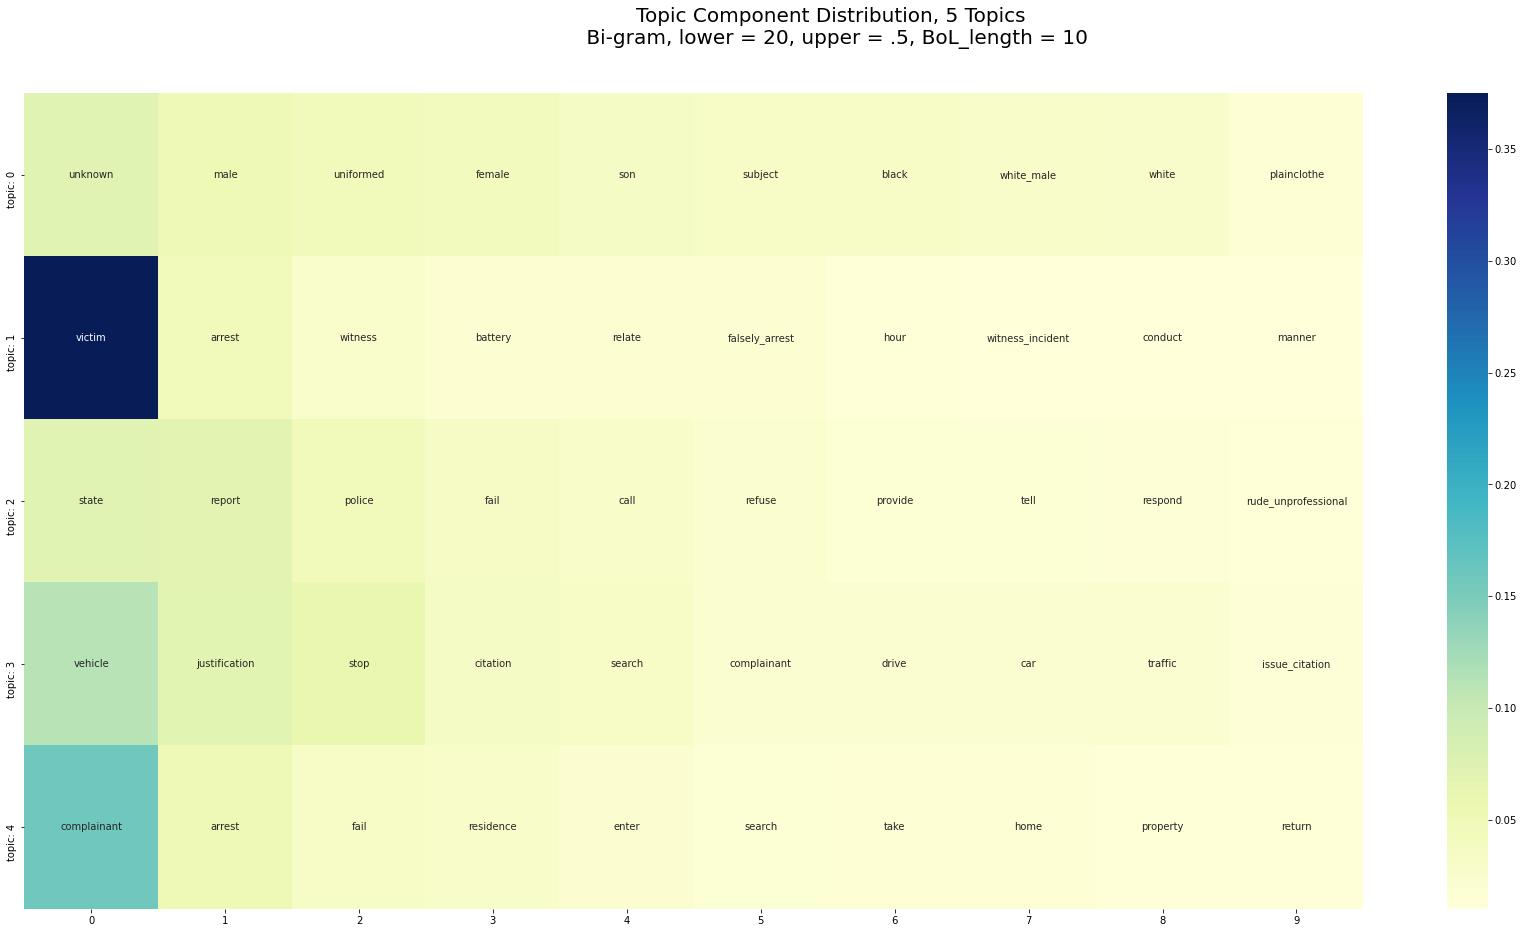

In [8]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n Bi-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_5topics1.png')

#### pyLDAvis Principal Component Visualization

In [9]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bigram_5topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Use

#### Most Represetative Documents


In [10]:
dom_topic_df_5 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_5 = PMC_module.return_top_representatives(dom_topic_df_5, num_reps = 10)

In [11]:
top_representatives_5[top_representatives_5['Dominant_Topic'] == 3].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
30,12098,3.0,0.7874,"[vehicle, justification, stop, citation, searc...","[allege, sept, stop, officer, wilfore, field, ...",It is alleged that on 29 Sept 26 ia\nwas stopp...
31,31262,3.0,0.7728,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
32,31261,3.0,0.7728,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, stop, searc...",The reporting party alleged that the accused\n...
33,10304,3.0,0.7618,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, officer, st...",THE REPORTING PARTY ALLEGES THAT\nTHE ACCUSED ...
34,7177,3.0,0.7547,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, officer, se...",The reporting party alleged that the accused\n...
35,32200,3.0,0.7511,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, stop, false...",The reporting party alleges that the accused\n...
36,32201,3.0,0.7511,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, stop, false...",The reporting party alleges that the accused\n...
37,4854,3.0,0.7374,"[vehicle, justification, stop, citation, searc...","[allege, durina, traffic, stop, accuse, exit, ...","It is alleged that durina a traffic stop, the\..."
38,8859,3.0,0.7367,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, traffic, stop, accu...",THE REPORTING PARTY ALLEGES THAT\nDURING A TRA...
39,568,3.0,0.7335,"[vehicle, justification, stop, citation, searc...","[reporting, party, allege, accuse, officer, st...",The reporting parties alleged that the\naccuse...


In [12]:
topic_of_interest = 3
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_5[top_representatives_5['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 3
---------
It is alleged that on 29 Sept 26 ia
was stopped by Officer Wilfore
Fields #12773 and Officer "Sanchez"
without justification and ticketed for blocking
traffic while driving into the parking lot of the
It is alleged that on 29 Sept 2013 that
was stopped by Officer Wilford
Fields #12773 and Officer "Sanchez"
without justification and ticketed for blocking
traffic while driving into the parking lot of the
------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three false citations.
------
The reporting party alleged that the accused
stopped and searched him without
justification. The accused also issued him
three fals

#### Topic Component Distribution - 10 topics

In [13]:
opt_topic_index = 1
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

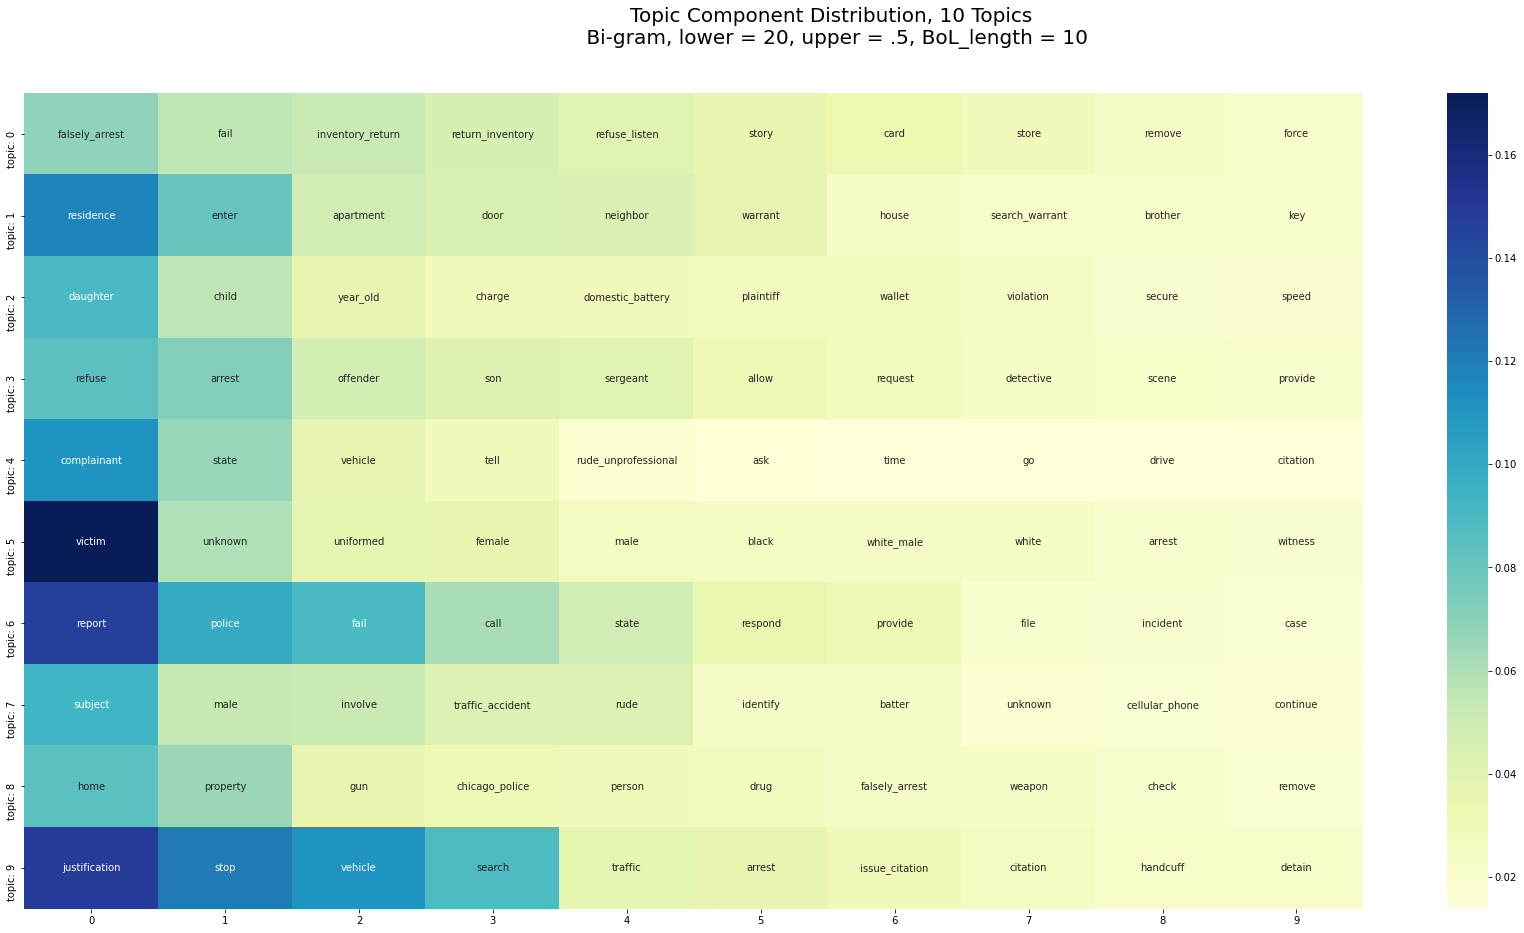

In [14]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 10 Topics \n Bi-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_10topics1.png')

#### pyLDAvis Principal Component Visualization

In [15]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bi_10topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [16]:
dom_topic_df_10 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_10 = PMC_module.return_top_representatives(dom_topic_df_10, num_reps = 10)

In [17]:
top_representatives_10[top_representatives_10['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,21118,0.0,0.5106,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, accuse, officer, re...",The reporting party alleges that the accused\n...
1,170,0.0,0.4895,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, accuse, officer, ru...",The reporting party alleged that the accused\n...
2,13345,0.0,0.4631,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, arrest, accuse, off...",THE REPORTING PARTY ALLEGES THAT\nDURING HIS A...
3,13346,0.0,0.4631,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, arrest, accuse, off...",THE REPORTING PARTY ALLEGES THAT\nDURING HIS A...
4,7151,0.0,0.4017,"[falsely_arrest, fail, inventory_return, retur...","[complainant, allege, accussed, falsely_arrest...",The complainant alleged that the accussed\nfal...
5,10411,0.0,0.3976,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, accuse, fail, inven...",The reporting party alleged that the accused\n...
6,169,0.0,0.3963,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, accuse, officer, ru...",The reporting party alleged that the accused\n...
7,30614,0.0,0.3667,"[falsely_arrest, fail, inventory_return, retur...","[allege, accuse, officer, fail, return_invento...",It is alleged that the accused officer failed ...
8,30613,0.0,0.3667,"[falsely_arrest, fail, inventory_return, retur...","[allege, accuse, officer, fail, return_invento...",It is alleged that the accused officer failed ...
9,4934,0.0,0.3660,"[falsely_arrest, fail, inventory_return, retur...","[reporting, party, allege, accuse, tow, vehicl...",The reporting party alleges that the accused\n...


In [18]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_10[top_representatives_10['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
orretumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retumed.
The reporting party alleges that the accused
officers removed his wallet that contained
$200.00 U.S.C. which was not inventoried
or retu

#### Topic Component Distribution - 15 topics

In [19]:
opt_topic_index = 2
topic_dict = {}
contribution_dict = {}
tuple_dict = {}

show_topics_output = model_lists[opt_topic_index].show_topics(num_topics=num_topics_list[opt_topic_index],formatted = False)
for i in range(len(show_topics_output)):
    row=show_topics_output[i]
    topic_dict["topic: "+str(i)] = [tuple[0] for tuple in row[1]]
    contribution_dict["topic: "+str(i)] = [tuple[1] for tuple in row[1]]    
    tuple_dict["topic: "+str(i)] = [tuple for tuple in row[1]]
    
contribution_df = pd.DataFrame(contribution_dict).T
topic_df = pd.DataFrame(topic_dict).T

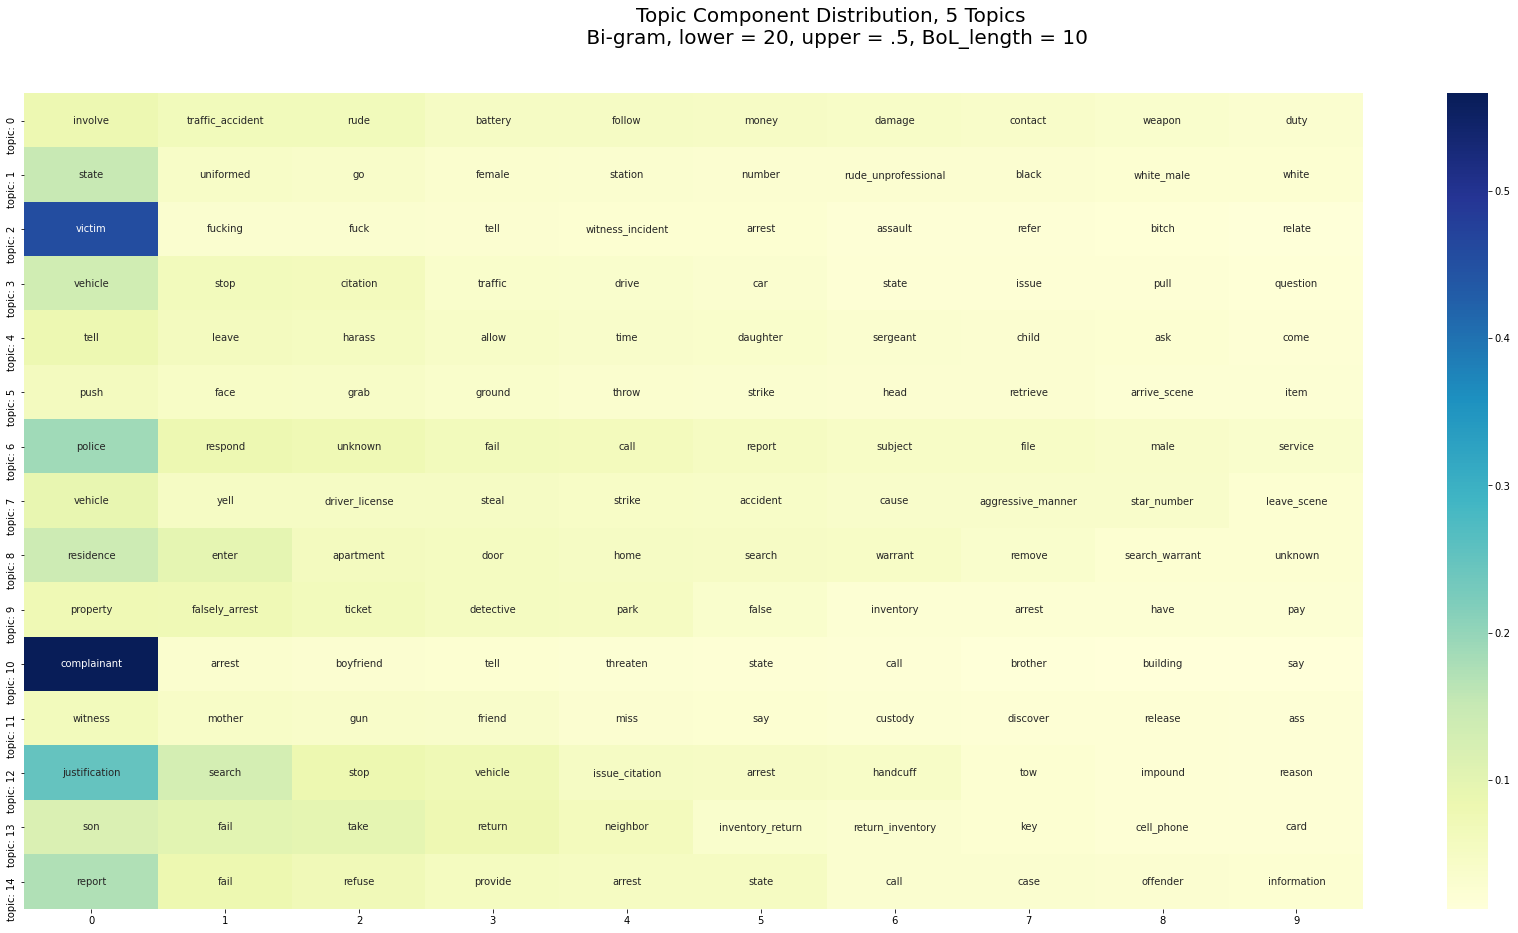

In [20]:
fig, ax = plt.subplots(1,1,figsize=(30,15))
ax = sns.heatmap(contribution_df, annot=topic_df,fmt = '', cmap="YlGnBu")
plt.suptitle("Topic Component Distribution, 5 Topics \n Bi-gram, lower = 20, upper = .5, BoL_length = 10", size = 20, y = .96)
plt.savefig('notebook_visualizations/topicdist_vis_combo_modeling_bigram_15topics1.png')

#### pyLDAvis Principal Component Visualization

In [21]:
# Visualize the topics
visualization_name = '../pyLDAvis/lda_vis_combo_bigram_15topics1.html'
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(model_lists[opt_topic_index], bi_corpus, bi_id2word)
pyLDAvis.save_html(vis, visualization_name)

/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/pedrogalarza/anaconda3/envs/spacy_env/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


#### Most Represetative Documents


In [22]:
dom_topic_df_15 = PMC_module.find_dominiant_topics(model_lists[opt_topic_index],bi_corpus, bigram_list_lemmatized_texts,df_list)
top_representatives_15 = PMC_module.return_top_representatives(dom_topic_df_15, num_reps = 10)

In [23]:
top_representatives_15[top_representatives_15['Dominant_Topic'] == 0].head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,bag,input_documents
0,268,0.0,0.5910,"[involve, traffic_accident, rude, battery, fol...","[duty_status, duty, reporting, party, allege, ...",Duty\nStatus ON Duty\nTHE REPORTING PARTY ALLE...
1,330,0.0,0.5122,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, accidentally_dischar...",It is alleged that the accused officer\naccide...
2,331,0.0,0.5122,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, accidentally_dischar...",It is alleged that the accused officer\naccide...
3,2097,0.0,0.4521,"[involve, traffic_accident, rude, battery, fol...","[duty_status, allegation, duty, allege, accuse...",Duty\nStatus\nAllegations\nOFF Duty\nIt is all...
4,3493,0.0,0.4257,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, improperly_dissemina...",It is alleged that the accused officer\nimprop...
5,3494,0.0,0.4257,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, improperly_dissemina...",It is alleged that the accused officer\nimprop...
6,18260,0.0,0.4124,"[involve, traffic_accident, rude, battery, fol...","[position_status, duty_status, active, police,...",Position\nStatus\nDuty\nStatus\nActive\nPOLICE...
7,13883,0.0,0.4030,"[involve, traffic_accident, rude, battery, fol...","[duly, duty_status, allegation, arrest, injury...",Duly on Duty\nStatus\nAllegations\nArrested? N...
8,12754,0.0,0.3974,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, inattentive_duty, fa...",It is alleged that the accused officer was\nin...
9,18635,0.0,0.3947,"[involve, traffic_accident, rude, battery, fol...","[allege, accuse, officer, inattentive_duty, ap...",It is alleged that the accused officer was\nin...


In [24]:
topic_of_interest = 0
print("Topic: {}".format(topic_of_interest))
print('---------')
for i in top_representatives_15[top_representatives_15['Dominant_Topic'] == topic_of_interest]['input_documents']:
    print(i)
    print('------')

Topic: 0
---------
Duty
Status ON Duty
THE REPORTING PARTY ALLEGES THAT DURING A COMMERCIAL ALARM CALL THE ACCUSED
OFFICER FAILED TO CONDUCT AN INVESTIGATION.
Arrested? No
Injuries? No
Medical? No
Allegations
CPD Employee
Role ACCUSED
Name LYBROOK, MICHAEL
Star No. 7339
Emp No. ii’
Unit No. 016/-
Position POLICE OFFICER Ct 107333a
Attecheren' ttt (Rye lo? 2)
14:33:00 PM Printed By: | Page 1 of 3
CPD 0579266
------
It is alleged that the accused officer
accidentally discharged a firearm, causing
damage to the front windshield of CPD
vehicle #9123. The firearm belongs to the
witness officer and was in the accused
officer's possession at the time of the
discharge
------
It is alleged that the accused officer
accidentally discharged a firearm, causing
damage to the front windshield of CPD
vehicle #9123. The firearm belongs to the
witness officer and was in the accused
officer's possession at the time of the
discharge.
------
Duty
Status
Allegations
OFF Duty
It is alleged that the accused v